## **Non-Learning Cross-Modal Baseline**

In this notebook, we demonstrate cross-modal retrieval accuracy on the QM9S dataset without relying on deep learning. The approach uses Morgan fingerprints generated with RDKit and measures cosine similarity between these fingerprints and vibrational spectra (IR and Raman).

To reproduce the results from this notebook, the user needs to download the supplementary data from the [Zenodo repository](https://doi.org/10.5281/zenodo.15348391), and place the `qm9s_ir_raman.pkl` file inside the data folder.

In [ ]:
# Import libraries
import os
import random
import pickle
import numpy as np
import pandas as pd
import scipy.interpolate as interp
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize-2.5}
sns.set(rc=rc)
sns.set_style('ticks')

In [2]:
# Load pickle file with QM9S dataset
with open("../data/qm9s_ir_raman.pkl", "rb") as p_file:
    qm9s_data = pickle.load(p_file)
p_file.close()

In [3]:
# Function to compute the morgan fingerprints from SMILES

def compute_morgan_fps(data, radius=2, n_bits=2048):
    # Empty dict to store fingerprints
    morgan_fps_dict = {}
    # Initialize fingerprint generator
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    # Loop over dataset
    for key, value in data.items():
        # Get the smiles rep
        smiles_rep = value["smile"]
        # Convert to rdkit mol object
        mol = Chem.MolFromSmiles(smiles_rep)
        # Saturate with Hs
        mol_hs = Chem.AddHs(mol)
        # Embed molecule
        has_conf = AllChem.EmbedMolecule(mol_hs, AllChem.ETKDG())
        # Check mol has conformation
        if has_conf == 0:
            # Get morgan fingerprints
            fp = morgan_gen.GetFingerprint(mol_hs)
            # Convert to numpy array
            arr = np.zeros((n_bits,), dtype=int)
            AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
            # Append to dict
            morgan_fps_dict.update({key: np.array(arr)})
        else:
            # Filtered smiles without conformer
            morgan_fps_dict.update({key: None})
    return morgan_fps_dict

In [4]:
# Collect all morgan fingerprints in a dict
morgan_fps_dict = compute_morgan_fps(data=qm9s_data)

In [5]:
# Shuffle and collect a random 10% as the test set
def sample_dict(data, fraction=0.1, seed=42):
    """Method to shuffle and select a fraction of dictionaries"""
    # Clean data from Nones
    data_clean = {k: v for k, v in data.items() if v is not None}
    # Shuffle indices
    keys = list(data_clean.keys())
    random.seed(seed)
    random.shuffle(keys)
    # Get fraction
    n_select = max(1, int(len(keys) * fraction))
    selected_keys = keys[:n_select]
    return {k: data_clean[k] for k in selected_keys}

# Generate the 10% random split
morgan_fps_dict_split = sample_dict(data=morgan_fps_dict, fraction=0.1)
indices_split_list = list(morgan_fps_dict_split.keys())

In [6]:
# Dictionary for index - SMILES relationship
index_to_smiles = {k: v["smile"] for k, v in qm9s_data.items()}

In [7]:
# Collect all IR and Raman spectra in different dicts

def interpolate_spec(arr, spec_dim=1750):
    """Method to interpolate the spectra into a given dimension"""
    # Initialize the interpolation method
    y_interp = interp.interp1d(np.arange(arr.size), arr)
    # Interpolate to a new dimension
    y_new = y_interp(np.linspace(0, arr.size - 1, spec_dim))
    return y_new

def normalize_spec(arr):
    """Method to normalize spectral data using MinMax method"""
    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Transform
    arr_scaled = scaler.fit_transform(arr.reshape(-1, 1))
    return arr_scaled.reshape(-1)


def collect_spectra(data, indices_split_list, spec_type="ir_spectra"):
    # Initialize empty dict for specs
    spectra_dict = {}
    # Loop over data
    for n in indices_split_list:
        # retrieve spectra as 2D array
        spectra = data[n][spec_type]
        # Interpolate only intensity (y-axis)
        spec_interp = interpolate_spec(spectra[1, :])
        # Normalize between 0 and 1
        spec_norm = normalize_spec(spec_interp)
        # Append to dict
        spectra_dict.update({n: spec_norm})
    return spectra_dict


In [8]:
# Generate IR and Raman spectra dicts
ir_spectra_dict = collect_spectra(data=qm9s_data, 
                                  indices_split_list=indices_split_list, 
                                  spec_type="ir_spectra"
)

raman_spectra_dict = collect_spectra(data=qm9s_data, 
                                     indices_split_list=indices_split_list, 
                                     spec_type="raman_spectra"
)

In [9]:
# Random projection head similar to VibraCLIP (without learning)

def random_projection_head(arr, out_dim=861, seed=42):
    """Method to project to out_dim using a fixed random matrix"""
    rng = np.random.default_rng(seed)
    # Create fixed matrix once (seeded)
    proj_matrix = rng.standard_normal((len(arr), out_dim))
    proj_matrix /= np.linalg.norm(proj_matrix, axis=0, keepdims=True)
    return arr @ proj_matrix

def generate_projected_dict(dict, indices_split_list, index_to_smiles):
    """Method to loop over data to project vectors from mols and spectra"""
    # Empty dict
    proj_dict = {}
    # Loop over data
    for n in indices_split_list:
        # Get SMILES
        smiles = index_to_smiles[n]
        # get array to be projected
        arr = dict[n]
        if arr is not None:
            # randomly project vector to a given dimension
            arr_proj = random_projection_head(arr, out_dim=861)
            # Append to dict
            proj_dict.update({str(smiles): arr_proj})
    return proj_dict

In [10]:
# Project morgan fingerprints and spectra
morgan_fps_dict_proj = generate_projected_dict(dict=morgan_fps_dict_split, 
                                               indices_split_list=indices_split_list,
                                               index_to_smiles=index_to_smiles,
)

ir_spectra_dict_proj = generate_projected_dict(dict=ir_spectra_dict, 
                                               indices_split_list=indices_split_list,
                                               index_to_smiles=index_to_smiles,
)

raman_spectra_dict_proj = generate_projected_dict(dict=raman_spectra_dict, 
                                                  indices_split_list=indices_split_list,
                                                  index_to_smiles=index_to_smiles,
)

In [16]:
# Retrieval strategy as vibraclip callback

def dual_retrieval(mol_dict, spectra_dict):
    """Method to quantify the retrieval accuracy for dual modalities (G, IR) or (G, Raman)"""
    # Empty dict
    similarities_dict = {}

    # Convert projected vectors to matrices
    mol_matrix = np.array(list(mol_dict.values()))
    spectra_matrix = np.array(list(spectra_dict.values()))

    # Pre-compute norms
    mol_norms = np.linalg.norm(mol_matrix, axis=1)
    spectra_norms = np.linalg.norm(spectra_matrix, axis=1)

    # Progress Bar
    pbar = tqdm(
        total=len(spectra_dict.keys()),
        desc="Dual Retrieval Strategy",
    )

    # Compute cosine similarity using matrix operations
    pbar_idx = 0
    for idx, (smile_target, s_emb_vec) in enumerate(spectra_dict.items()):
        # Calculate similarities
        similarities = np.dot(mol_matrix, s_emb_vec) / (mol_norms * spectra_norms[idx])

        # Create dict with similarities
        candidates_dict = {
            str(key): float(sim)
            for key, sim in zip(mol_dict.keys(), similarities)
        }

        # Sorting
        candidates_dict_sort = dict(
            sorted(
                candidates_dict.items(),
                key=lambda item: item[1],
                reverse=True,
            )
        )

        # Append candidates dict
        similarities_dict.update({str(smile_target): candidates_dict_sort})

        # Update pbar
        pbar_idx += 1
        pbar.update(1)

    return similarities_dict


In [17]:
# Dual Retrieval
ir_similarities = dual_retrieval(mol_dict=morgan_fps_dict_proj, 
                                 spectra_dict=ir_spectra_dict_proj
)

raman_similarities = dual_retrieval(mol_dict=morgan_fps_dict_proj,
                                    spectra_dict=raman_spectra_dict_proj
)

Dual Retrieval Strategy: 100%|██████████| 12740/12740 [01:17<00:00, 165.39it/s]


In [18]:
# Dual Retrieval Accuracy

def top_k_accuracy(retrieved, relevant_item, k):
    """Measures the proportion of relevant items in the top K retrieved results"""
    acc = 1.0 if relevant_item in retrieved[:k] else 0.0
    index = retrieved.index(relevant_item) + 1
    return acc, index

def retrieval_accuracy_dict(data):
    """Method to compute the retrieval accuracy based on the similatiries dict"""
    # Get number of total entries in the split
    num_labels = len(list(data.keys()))
    # Initialize accumulators for each top K value
    top_k_values = [1, 5, 10, 15, 20, 25]
    total_acc = {k: 0 for k in top_k_values}

    # Loop over the data
    top_k_dict = {k: [] for k in top_k_values}
    for idx, (smile_target, smile_cand) in tqdm(enumerate(data.items())):
        # Get the candidates labels
        sorted_labels = list(smile_cand.keys())

        # Compute accuracy for each K and update the corresponding total
        for k in top_k_values:
            top_k_acc, top_k_idx = top_k_accuracy(retrieved=sorted_labels, relevant_item=smile_target, k=k)
            total_acc[k] += top_k_acc
            # Storing positive ones
            if top_k_acc == 1 and top_k_idx == k:
                top_k_dict[k].append({smile_target: smile_cand})
    
    # Calculate average accuracies
    top_k_acc_dict = {}
    for k in top_k_values:
        avg_acc = total_acc[k] / num_labels
        top_k_acc_dict.update({str(k): avg_acc})
    return top_k_acc_dict

In [19]:
# Get Retrieval Accuracies for dual retrieval
ir_top_acc_dict = retrieval_accuracy_dict(data=ir_similarities)

raman_top_acc_dict = retrieval_accuracy_dict(data=raman_similarities)

12740it [00:03, 3574.93it/s]
12740it [00:03, 3551.09it/s]


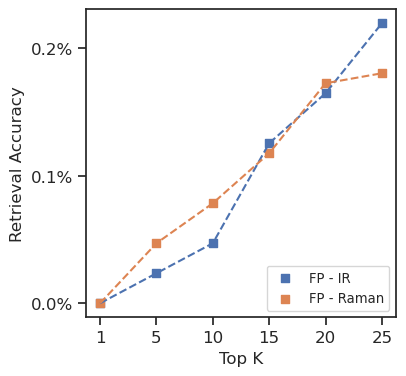

In [21]:
# Dual retrieval accuracy plot
## IR
plt.plot(list(ir_top_acc_dict.keys()), list(ir_top_acc_dict.values()), "--")
plt.scatter(list(ir_top_acc_dict.keys()), list(ir_top_acc_dict.values()), marker="s", label="FP - IR")
## Raman
plt.plot(list(raman_top_acc_dict.keys()), list(raman_top_acc_dict.values()), "--")
plt.scatter(list(raman_top_acc_dict.keys()), list(raman_top_acc_dict.values()), marker="s", label="FP - Raman")
# Settings
plt.yticks(np.arange(0, 0.0021, 0.001), [f"{ytick * 100:.1f}%" for ytick in np.arange(0, 0.0021, 0.001)])
plt.xlabel("Top K")
plt.ylabel("Retrieval Accuracy")
plt.legend(loc="lower right")
plt.savefig("./dual_retrieval_morgan_fp.svg")